# tSNE plots with ingredients

In this notebook, we try to make some tSNE plot with ingredient features. We will see if products of same category would appear closer to each other on the tSNE plot. It didn't "quite" work out, but gives us an initial idea of which categories are hard to distinguish...

In [1]:
import sys
sys.path.append('../utilities')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.manifold import TSNE
import itertools
from data_utils import *

#### Read data and compute "bag of ingredient"

In [2]:
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
df = skin_care_df.loc[~skin_care_df['ingredient'].isnull()]

ingredient_count_df = get_matching_ingredient_count(df)
ingredient_count_df.head()

,glycerol monostearate,ethylhexyl olivate,tetrasodium EDTA,Corylus avellana,Rhodiola rosea root extract,pine oil,Saccharomyces officinarum ferment,olive oil,hydrogen peroxide,pansy extract,...,ceresin,tremella fuciformis sporocarp extract,gold,Euphorbia cerifera wax,walnut shell powder,eucalyptus extract,mandelic acid,coco-glucoside,thyme oil,arachidyl alcohol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### tNSE using all ingredient binary count

In [3]:
model = TSNE(random_state=777, verbose=1)
tsne_vec = model.fit_transform(ingredient_count_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4988 samples in 0.785s...
[t-SNE] Computed neighbors for 4988 samples in 87.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4988
[t-SNE] Computed conditional probabilities for sample 2000 / 4988
[t-SNE] Computed conditional probabilities for sample 3000 / 4988
[t-SNE] Computed conditional probabilities for sample 4000 / 4988
[t-SNE] Computed conditional probabilities for sample 4988 / 4988
[t-SNE] Mean sigma: 1.157483
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.761597
[t-SNE] Error after 1000 iterations: 2.691320


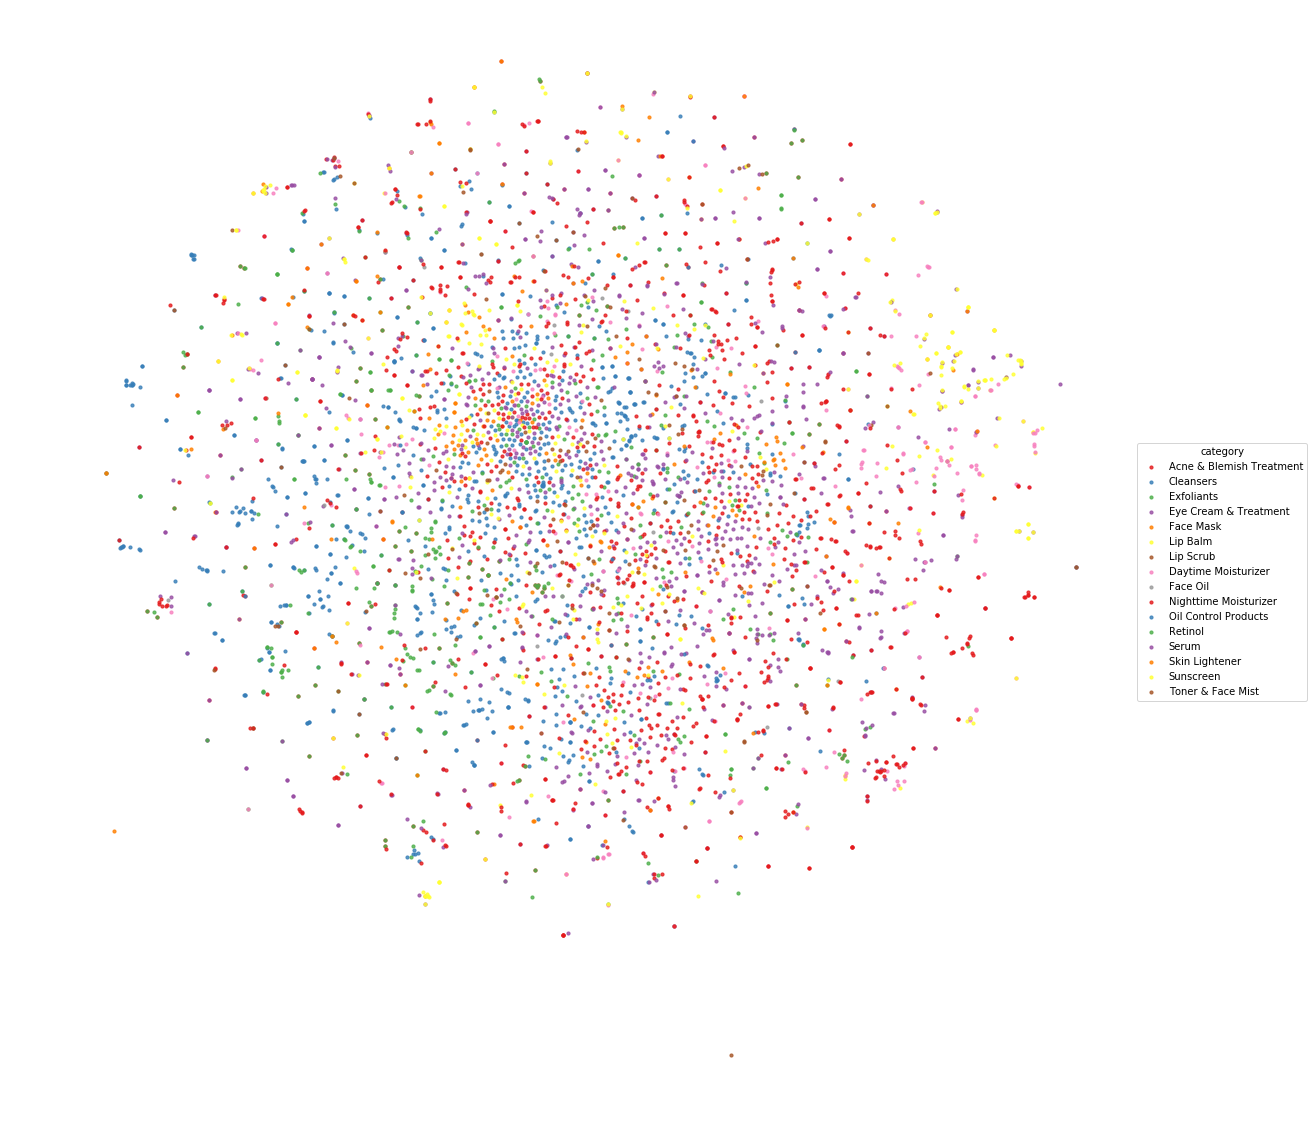

In [4]:
x, y = tsne_vec[:,0], tsne_vec[:,1]
tsne_df = pd.DataFrame()
tsne_df['x'] = x
tsne_df['y'] = y
tsne_df['category'] = df['product_category']
sns.lmplot(x='x', y='y', hue='category', data=tsne_df, fit_reg=False, scatter_kws={"s": 10}, size=16, palette='Set1')
plt.axis('off')
plt.show()

Hmm... It didn't work out. We don't see products belonging to the same category come close together. The reason may be that there are too much noise with all the ingredient count. Those ingredient that are less relevant to product category contribute equally to the tSNE model, making it hard to reveal the pattern related to product category.

#### tSNE using other ingredient info (rating, category count)

Try tSNE with other ingredient-related features. We will also only plot some large categories to make the plot easier to see.

In [5]:
ingredient_df_short = pd.concat([df[['n_inactive_ingredient','n_active_ingredient']].reset_index(drop=True), 
           df.loc[:,'inactive_rating_count_0.0':].reset_index(drop=True)], axis=1)
ingredient_df_short['active_mean_rating'].fillna(-1, inplace=True)

In [6]:
model = TSNE(random_state=777, verbose=1)
tsne_vec2 = model.fit_transform(ingredient_df_short)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4988 samples in 0.018s...
[t-SNE] Computed neighbors for 4988 samples in 1.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4988
[t-SNE] Computed conditional probabilities for sample 2000 / 4988
[t-SNE] Computed conditional probabilities for sample 3000 / 4988
[t-SNE] Computed conditional probabilities for sample 4000 / 4988
[t-SNE] Computed conditional probabilities for sample 4988 / 4988
[t-SNE] Mean sigma: 3.174785
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.845375
[t-SNE] Error after 1000 iterations: 1.568405


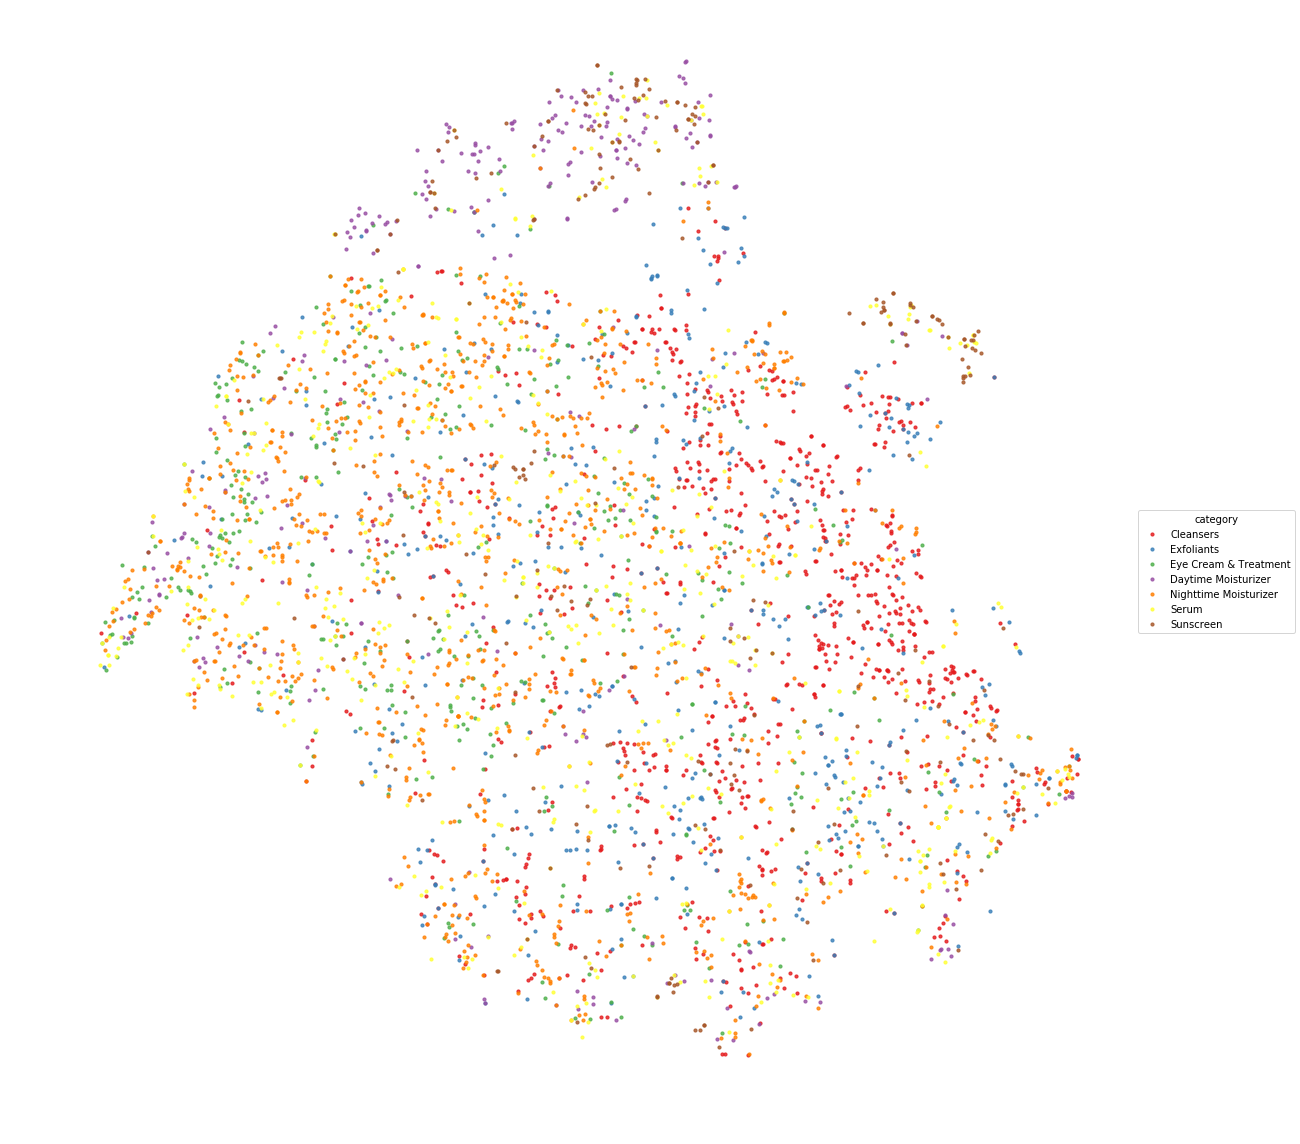

In [7]:
x, y = tsne_vec2[:,0], tsne_vec2[:,1]
tsne_df = pd.DataFrame()
tsne_df['x'] = x
tsne_df['y'] = y
tsne_df['category'] = df['product_category']
tsne_df['category'].fillna('unknown', inplace=True)
large_categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum', 'Exfoliants', 
                    'Eye Cream & Treatment', 'Daytime Moisturizer', 'Sunscreen']
sns.lmplot(x='x', y='y', hue='category', data=tsne_df.loc[tsne_df.category.isin(large_categories)], 
           fit_reg=False, scatter_kws={"s": 10}, size=16, palette='Set1')
plt.axis('off')
plt.show()

#### tSNE using other ingredient info (rating, category count) and selected individule ingredient (by chi2)

In [8]:
from sklearn.feature_selection import chi2
chi2s, p_values = chi2(ingredient_count_df, df['product_category'])
feature_p_values = pd.Series(p_values, index = ingredient_count_df.columns.values)
print("top ingredients")
print(feature_p_values.sort_values().head(20))
column_filter = feature_p_values < 1e-10
print("number of selected ingredients:", column_filter.sum())

ingredient_df = pd.concat([df[['n_inactive_ingredient','n_active_ingredient']].reset_index(drop=True), 
           df.loc[:,'inactive_rating_count_0.0':].reset_index(drop=True),
           ingredient_count_df.loc[:,column_filter]], axis=1)
ingredient_df['active_mean_rating'].fillna(-1, inplace=True)
ingredient_df.shape

top ingredients
avobenzone                  0.000000e+00
octisalate                  0.000000e+00
octocrylene                 0.000000e+00
homosalate                 2.947209e-289
oxybenzone                 2.268243e-273
flavor                     8.013737e-272
octinoxate                 1.256149e-259
Ricinus communis           8.231215e-225
salicylic acid             1.446107e-180
red 27 lake                3.341558e-173
cocamidopropyl betaine     3.545688e-155
kaolin                     1.037815e-151
dimethicone                7.291579e-137
retinol                    1.476441e-130
hydroquinone               2.532123e-122
glycolic acid              2.985055e-106
zinc oxide                 1.209851e-105
Copernicia cerifera wax    1.777189e-103
triethoxycaprylylsilane    1.158848e-100
sodium laureth sulfate     5.056374e-100
dtype: float64
number of selected ingredients: 238


(4988, 304)

In [9]:
model = TSNE(random_state=777, verbose=1)
tsne_vec3 = model.fit_transform(ingredient_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4988 samples in 0.093s...
[t-SNE] Computed neighbors for 4988 samples in 8.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4988
[t-SNE] Computed conditional probabilities for sample 2000 / 4988
[t-SNE] Computed conditional probabilities for sample 3000 / 4988
[t-SNE] Computed conditional probabilities for sample 4000 / 4988
[t-SNE] Computed conditional probabilities for sample 4988 / 4988
[t-SNE] Mean sigma: 3.284644
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.250076
[t-SNE] Error after 1000 iterations: 1.581448


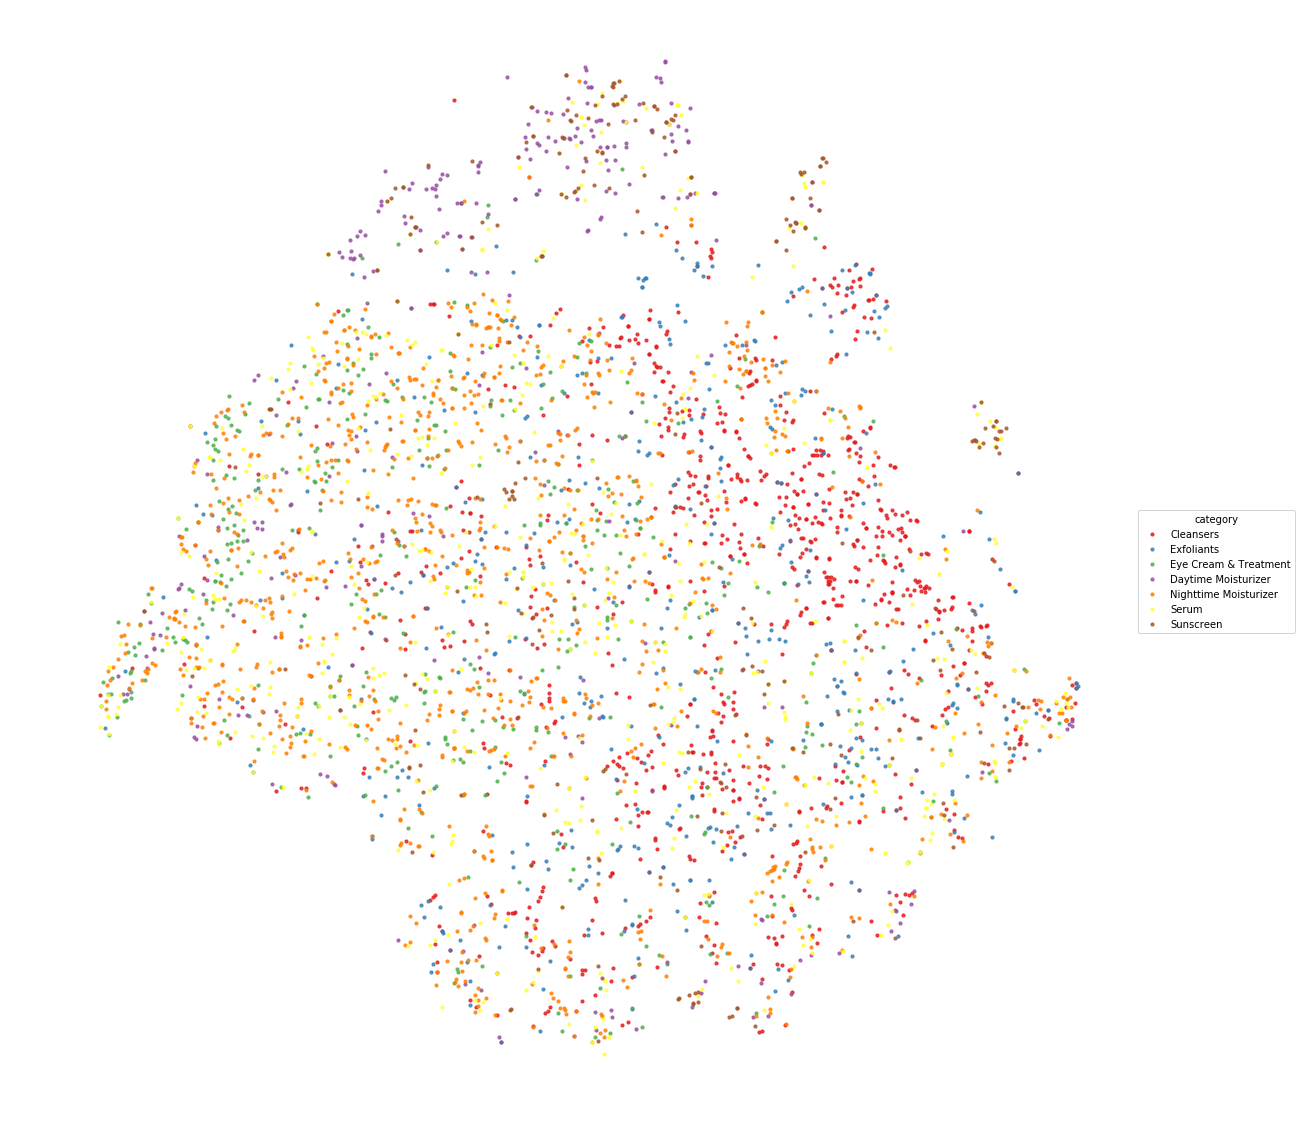

In [10]:
x, y = tsne_vec3[:,0], tsne_vec3[:,1]
tsne_df = pd.DataFrame()
tsne_df['x'] = x
tsne_df['y'] = y
tsne_df['category'] = df['product_category']
tsne_df['category'].fillna('unknown', inplace=True)
large_categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum', 'Exfoliants', 
                    'Eye Cream & Treatment', 'Daytime Moisturizer', 'Sunscreen']
sns.lmplot(x='x', y='y', hue='category', data=tsne_df.loc[tsne_df.category.isin(large_categories)], 
           fit_reg=False, scatter_kws={"s": 10}, size=16, palette='Set1')
plt.axis('off')
plt.show()

So after pruning individuel ingredients and add other features such as count/rating, we are able to do a little better. There is a vague cluster of cleansers (red dots), and a cluster which is mostly a mixture of sunscreen and daytime moisturizer (purple and brown dots). Eye creams, nighttime moisturizer and serums tend to mix together, which is not a surprise as they are similar after all. But surely, we would want to do supervised learning to see if we can distiguish product category further.